# Milvus 기반 벡터정보 시각화 예시

- 참고문헌 : https://milvus.io/docs/ko/vector_visualization.md
- umap를 사용해 Milvus의 임베딩(벡터)을 시각화하는 방법
- umap와 같은 차원 축소 기술은 로컬 구조를 유지하면서 2D 또는 3D 공간에서 복잡한 고차원 데이터를 시각화하는 데 매우 유용


## Milvus 연결 테스트

In [23]:
from pymilvus import Collection, CollectionSchema, FieldSchema, DataType, connections, utility

# Milvus 서버에 연결
connections.connect("default", host='localhost', port='19530')

# 필드 스키마 정의
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="vector_field", dtype=DataType.FLOAT_VECTOR, dim=128)
]

# 콜렉션 스키마 생성
schema = CollectionSchema(fields, description="Test collection")

# 콜렉션 생성
collection_name = "example_collection"
if collection_name not in utility.list_collections():
    collection = Collection(name=collection_name, schema=schema)
    print(f"Collection {collection_name} created.")
else:
    print(f"Collection {collection_name} already exists.")


Collection example_collection already exists.


## 종속성 해결

```bash
pip install --upgrade pymilvus openai requests tqdm matplotlib seaborn
```

## 시험용 데이터 다운로드 및 압축 풀기

```bash
$ wget https://github.com/milvus-io/milvus-docs/releases/download/v2.4.6-preview/milvus_docs_2.4.x_en.zip
$ unzip -q milvus_docs_2.4.x_en.zip -d milvus_docs
```

## 데이터 로드

- milvus_docs/en/faq 폴더에서 모든 마크다운 파일을 로드
- 각 문서에 대해 "#"를 사용하여 파일의 내용을 구분하기만 하면 마크다운 파일의 각 주요 부분의 내용을 대략적으로 구분 가능


In [24]:
from glob import glob

text_lines = []

for file_path in glob("milvus_docs/en/faq/*.md", recursive=True):
    with open(file_path, "r") as file:
        file_text = file.read()

    text_lines += file_text.split("# ")

In [25]:
'''
from glob import glob

text_lines = []

for file_path in glob("milvus_docs/ko/md/*.md", recursive=True):
    with open(file_path, "r") as file:
        file_text = file.read()

    text_lines += file_text.split("# ")
'''

'\nfrom glob import glob\n\ntext_lines = []\n\nfor file_path in glob("milvus_docs/ko/md/*.md", recursive=True):\n    with open(file_path, "r") as file:\n        file_text = file.read()\n\n    text_lines += file_text.split("# ")\n'

In [26]:
len( text_lines )

72

## 임베딩 모델 준비

- 허깅페이스에서 모델 다운로드

In [27]:
from transformers import AutoTokenizer, AutoModel
import torch

def load_model(model_name="sentence-transformers/all-MiniLM-L6-v2"):
    # 모델과 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    return tokenizer, model

def emb_text(text, tokenizer, model):
    # 텍스트를 토큰으로 변환
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    # 모델에 입력하여 임베딩을 생성
    with torch.no_grad():
        model_output = model(**encoded_input)
    # 임베딩 추출 (평균을 사용하여 문장 임베딩을 생성)
    embeddings = model_output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# 사용 예시
tokenizer, model = load_model()
text = "여기에 분석할 텍스트를 입력하세요."
embedding = emb_text(text, tokenizer, model)
print(embedding[:10])


[ 0.01337682  0.05869813 -0.07439305 -0.06315488 -0.11086049 -0.13148424
 -0.10424639  0.15587312 -0.01671412 -0.07906346]


In [28]:
test_embedding = emb_text("This is a test", tokenizer, model)
embedding_dim = len(test_embedding)
print(embedding_dim)
print(test_embedding[:10])

384
[ 0.16668403  0.07531183 -0.11349392  0.08890492 -0.05571029 -0.26127303
 -0.09427059  0.20302933  0.2498555   0.1873345 ]


## Milvus에 데이터 로드

- collection 생성


In [39]:
from pymilvus import MilvusClient

milvus_client = MilvusClient(uri="./milvus_demo3.db")

collection_name = "my_rag_collection"

### 컬렉션이 이미 존재하는지 확인하고 존재한다면 삭제

In [40]:
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

## 지정된 파라미터로 새 컬렉션을 생성

- 필드 정보를 지정하지 않으면 기본 키로 id 필드와 벡터 데이터를 저장할 vector 필드가 자동으로 생성
- 예약된 JSON 필드는 스키마에 정의되지 않은 필드와 그 값을 저장하는 데 사용

In [41]:
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=embedding_dim,
    metric_type="IP",  # Inner product distance
    consistency_level="Strong",  # Strong consistency level
)


## 데이터 삽입

- 텍스트 줄을 반복하여 임베딩을 만든 다음 데이터를 Milvus에 삽입
- 다음은 컬렉션 스키마에 정의되지 않은 필드인 새 필드 text
- 이 필드는 예약된 JSON 동적 필드에 자동으로 추가되며, 상위 수준에서 일반 필드로 취급될 수 있음

In [42]:
from tqdm import tqdm

data = []

for i, line in enumerate(tqdm(text_lines, desc="Creating embeddings")):
    data.append({"id": i, "vector": emb_text(line, tokenizer, model), "text": line})

milvus_client.insert(collection_name=collection_name, data=data)


Creating embeddings: 100%|███████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 179.73it/s]


{'insert_count': 72, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], 'cost': 0}

## 벡터 검색에서 임베딩 시각화하기

### 쿼리에 대한 데이터 검색
- 검색을 위한 질문을 준비

In [43]:

question = "How is data stored in Milvus?"
#question = "latex"


- 컬렉션에서 질문을 검색하고 시맨틱 상위 5개 일치 항목을 검색

In [44]:
search_res = milvus_client.search(
    collection_name=collection_name,
    data=[
        emb_text(question, tokenizer, model)
    ],  # Use the `emb_text` function to convert the question to an embedding vector
    limit=5,  # Return top 10 results
    search_params={"metric_type": "IP", "params": {}},  # Inner product distance
    output_fields=["text"],  # Return the text field
)


- 쿼리의 검색 결과 확인

In [45]:
import json

retrieved_lines_with_distances = [
    (res["entity"]["text"], res["distance"]) for res in search_res[0]
]
print( json.dumps(retrieved_lines_with_distances, indent=4) )


[
    [
        "What data types does Milvus support on the primary key field?\n\nIn current release, Milvus supports both INT64 and string.\n\n###",
        16.94402313232422
    ],
    [
        "Why is there no vector data in etcd?\n\netcd stores Milvus module metadata; MinIO stores entities.\n\n###",
        14.801624298095703
    ],
    [
        "How does Milvus flush data?\n\nMilvus returns success when inserted data are loaded to the message queue. However, the data are not yet flushed to the disk. Then Milvus' data node writes the data in the message queue to persistent storage as incremental logs. If `flush()` is called, the data node is forced to write all data in the message queue to persistent storage immediately.\n\n###",
        13.231996536254883
    ],
    [
        "Does Milvus support Apple M1 CPU?\n\nCurrent Milvus release does not support Apple M1 CPU.\n\n###",
        11.612100601196289
    ],
    [
        "Can vectors with duplicate primary keys be inserted into

## umap 통해 2차원으로 차원 축소

- pip install umap-learn


In [46]:
import pandas as pd
import numpy as np
import umap

# 데이터 추가 (data는 이미 정의되어 있어야 합니다)
data.append({"id": len(data), "vector": emb_text(question, tokenizer, model), "text": question})

# 임베딩 추출
embeddings = [gp["vector"] for gp in data]

# numpy 배열로 변환
X = np.array(embeddings, dtype=np.float32)

# UMAP 객체 생성 및 학습
reducer = umap.UMAP(random_state=0)
umap_results = reducer.fit_transform(X)

# 결과를 DataFrame으로 변환
df_umap = pd.DataFrame(umap_results, columns=["UMAP1", "UMAP2"])
df_umap


2025-03-06 19:10:56.788831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-06 19:10:56.788848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jpark/www/venv_base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2
0,3.341798,8.575440
1,3.247270,8.957843
2,4.915676,7.382388
3,4.043700,6.990090
4,4.573033,7.193195
...,...,...
68,7.072521,10.104492
69,6.109464,9.773411
70,7.160749,9.969773
71,5.665870,10.128148


## 2차원 평면에서 Milvus 검색 결과 시각화

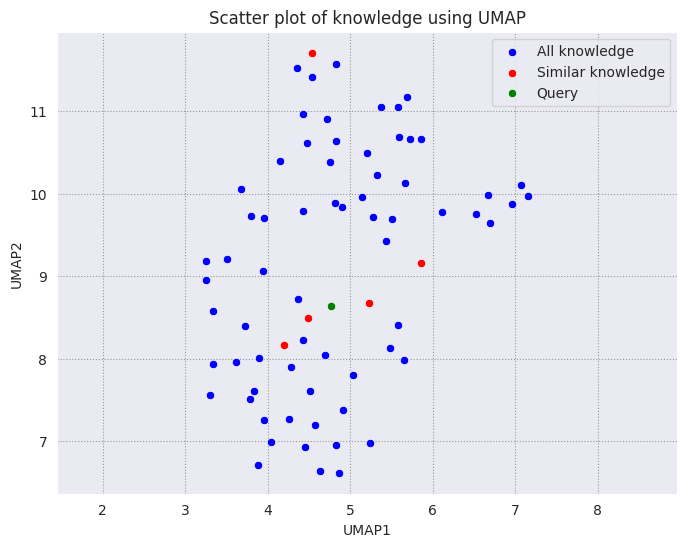

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

similar_ids = [gp["id"] for gp in search_res[0]]

df_norm = df_umap[:-1]

df_query = pd.DataFrame(df_umap.iloc[-1]).T

similar_points = df_umap[df_umap.index.isin(similar_ids)]

fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

sns.scatterplot(
    data=df_umap, x="UMAP1", y="UMAP2", color="blue", label="All knowledge", ax=ax
)

sns.scatterplot(
    data=similar_points,
    x="UMAP1",
    y="UMAP2",
    color="red",
    label="Similar knowledge",
    ax=ax,
)

sns.scatterplot(
    data=df_query, x="UMAP1", y="UMAP2", color="green", label="Query", ax=ax
)

plt.title("Scatter plot of knowledge using UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

plt.axis("equal")

plt.legend()

plt.show()
